# Dfsu - Connectivity

In [1]:
import mikeio

<AxesSubplot:title={'center':'Bathymetry'}>

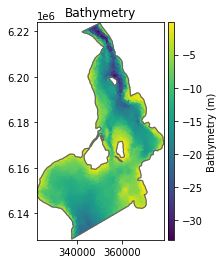

In [22]:
ds = mikeio.read("../tests/testdata/oresundHD_run1.dfsu")
ds.geometry.plot()

The info on the connectivity between nodes and elements can be found in the element table

In [23]:
et = ds.geometry.element_table
len(et)

3612

In [24]:
et[0]

array([718, 229, 143])

Let's find out if any of these nodes are also found in another element, this would imply that these elements are neigbours (adjacent).

In [25]:
for i, e in enumerate(et):
    for n in et[0]:
        if n in e:
            print(f"Node: {n} found in element {i}")

Node: 718 found in element 0
Node: 229 found in element 0
Node: 143 found in element 0
Node: 229 found in element 701
Node: 718 found in element 743
Node: 143 found in element 765
Node: 143 found in element 973
Node: 718 found in element 974
Node: 718 found in element 2000
Node: 229 found in element 2000
Node: 229 found in element 2080
Node: 718 found in element 2081
Node: 718 found in element 2982
Node: 143 found in element 2982


This information can be encoded in a connectivity matrix, and since each element is only connected to a few other elements, this will be a very sparse matrix, which is why we will store this info in a suitable sparse matrix structure from [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html).

In [31]:
from scipy.sparse import lil_matrix

In [32]:
ne = ds.geometry.n_elements

In [33]:
nodetable = {}
for el in range(ds.geometry.n_elements):
    nodes = et[el]

    for node in nodes:
        if node in nodetable:
            nodetable[node].append(el)
        else:
            nodetable[node] = [el]

In [35]:
def is_neighbour(a, b) -> bool:
    return len(set(a).intersection(set(b))) == 2

In [42]:
# create table with neighbours
ec = {}
for el in range(ne):
    nodes = et[el] # nodes in this element

    for n in nodes:
        elements = nodetable[n] # elements that has this node 
        for e in elements:
            if is_neighbour(et[el], et[e]):
                if el in ec:
                    if e not in ec[el]:
                        ec[el].append(e)
                else:
                    ec[el] = [e]

       

In [43]:
# Create sparse connectivity matrix
C = lil_matrix((ne, ne))
for i in range(ne):
    row = ec[i]
    for j in row:
        C[i, j] = 1

In [44]:
C

<3612x3612 sparse matrix of type '<class 'numpy.float64'>'
	with 10350 stored elements in List of Lists format>

In [45]:
C[0,0] # Self connection are not included

0.0

In [19]:
C[0,2] # Element 0 and 2 are connected

1.0

Once we have the connectivity matrix, we can do some other interesting things, like clustering with connectivity constraints.

## Clustering

In [46]:
ds

<mikeio.Dataset>
Geometry: Dfsu2D
Dimensions: (time:5, element:3612)
Time: 2018-03-07 00:00:00 - 2018-03-11 00:00:00 (5 records)
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Total water depth <Water Depth> (meter)
  2:  U velocity <u velocity component> (meter per sec)
  3:  V velocity <v velocity component> (meter per sec)

In [60]:
data = ds.Surface_elevation.values.T
data.shape

(3612, 5)

In [61]:
from sklearn.cluster import AgglomerativeClustering

c = AgglomerativeClustering(
            n_clusters=10, connectivity=C, linkage="ward"
    ).fit(data)

In [62]:
c.labels_

array([8, 9, 7, ..., 0, 0, 0], dtype=int64)

In [66]:
da = mikeio.DataArray(c.labels_, geometry=ds.geometry, item="Cluster #")
da

<mikeio.DataArray>
Name: Cluster #
Geometry: Dfsu2D
Dimensions: (element:3612)
Time: 2018-01-01 00:00:00 (time-invariant)

<AxesSubplot:title={'center':'2018-01-01 00:00:00'}>

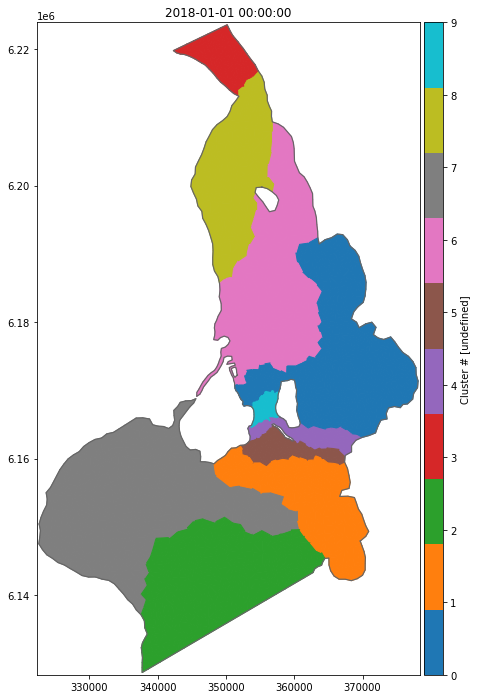

In [70]:
da.plot(figsize=(12,12), cmap='tab10')